In [1]:
from imp import reload
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
import datetime
from  tqdm import tqdm
import math, os

import data_generator
reload(data_generator)
import hparams
reload(hparams)
import model_unet
reload(model_unet)
import numpy as np
import loss_function
reload(loss_function)
import utils
reload(utils)
import evaluate

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda:0 device


In [2]:
# 一个epoch的训练+测试
def train(dataloader, model, loss_fn, optimizer, scheduler, out_floor):
    model.train()
    size = len(dataloader.dataset)
    batch_num = math.ceil(size/dataloader.batch_size)
    loss_total = 0
    
    for batch, (X, y) in tqdm(enumerate(dataloader)): # 每次返回一个batch
        # X, y = X.cuda(device=device_ids[0]), y.cuda(device=device_ids[0])
        X, y = X.cuda(), y.cuda()
        # Compute prediction error
        pred = model(X, out_floor)
        
        if out_floor == 0:
            loss = loss_fn(pred, y)
        else:
            # downsample y
            y_downsample = utils.downsample(y, out_floor)
            # print(pred.shape, y_downsample.shape)
            loss = loss_fn(pred, y_downsample)
            
        # 对于某些特殊的损失函数：
        if args.loss in [2,3]:
            loss = (loss[0].sum()+loss[2].sum())/(loss[1].sum()+loss[3].sum())
        elif args.loss in [0,1]:
            loss = loss.sum()
            
        loss_total += loss.item()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch+1) % 50 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Avg loss: {loss:.4f}  [{current:>5d}/{size:>5d}]")
            
    scheduler.step()
    return loss_total/batch_num

threshold = 0
args_loss = 3
def test(dataloader, model, loss_fn, out_floor):
    
    with torch.no_grad():
    
        size = len(dataloader.dataset)
        batch_num = math.ceil(size/dataloader.batch_size)

        model.eval()
        test_loss = 0
        test_loss_v, test_loss_nv = 0, 0
        test_loss_f, test_loss_t = 0, 0
        oa_avg, vr_avg, vfa_avg, rpa_avg, rca_avg = 0, 0, 0, 0, 0
    
    
        for X, y in tqdm(dataloader):
            # X, y = X.cuda(device=device_ids[0]), y.cuda(device=device_ids[0])
            X, y = X.cuda(), y.cuda()
            Xpred = model(X, out_floor)
            Xout = utils.salience_to_output(Xpred.clone().detach(), threshold=threshold)
            
            if out_floor == 0:
                loss = loss_fn(Xpred, y, threshold)
                oa, vr, vfa, rpa, rca = evaluate.evaluate(Xout, y, out_floor)
            else:
                y_downsample = utils.downsample(y, out_floor)
                loss = loss_fn(Xpred, y_downsample, threshold)
                oa, vr, vfa, rpa, rca = evaluate.evaluate(Xout, y_downsample, out_floor)
                
            if args_loss == 2:
                loss_gather = (loss[0].sum()+loss[2].sum())/(loss[1].sum()+loss[3].sum())
                loss_v_gather = loss[0].sum()/loss[1].sum()
                loss_nv_gather = loss[2].sum()/loss[3].sum()
                test_loss_v += loss_v_gather.item()
                test_loss_nv += loss_nv_gather.item()
            elif args_loss == 3:
                loss_gather = (loss[0].sum()+loss[2].sum())/(loss[1].sum()+loss[3].sum())
                loss_f_gather = loss[0].sum()/loss[1].sum()
                loss_t_gather = loss[2].sum()/loss[3].sum()
                test_loss_f += loss_f_gather.item()
                test_loss_t += loss_t_gather.item()
            elif args_loss in [0,1]:
                loss_gather = loss.sum()
            
            if loss_gather.item() != loss_gather.item():
                print('nan!')
            test_loss += loss_gather.item()

            
            oa_avg += oa
            vr_avg += vr
            vfa_avg += vfa
            rpa_avg += rpa
            rca_avg += rca
            
    test_loss /= batch_num # 每张图的loss
    test_loss_v /= batch_num
    test_loss_nv /= batch_num
    test_loss_f /= batch_num
    test_loss_t /= batch_num
    
    oa_avg /= batch_num
    vr_avg /= batch_num
    vfa_avg /= batch_num
    rpa_avg /= batch_num
    rca_avg /= batch_num
    
    print(f"Test Error: Avg loss: {test_loss:.4f} \n")
    print(f"Test OA\t{oa_avg:.4f}\tVR\t{vr_avg:.4f}\tVFA\t{vfa_avg:.4f}\tRPA\t{rpa_avg:.4f}\tRCA\t{rca_avg:.4f}\n")
    
    if args_loss in [0,1,2]:
        return (test_loss, test_loss_v, test_loss_nv), oa_avg, vr_avg, vfa_avg, rpa_avg, rca_avg
    elif args_loss in [3]:
        return (test_loss, test_loss_f, test_loss_t), oa_avg, vr_avg, vfa_avg, rpa_avg, rca_avg

# split data, generate train/test_dataloader

In [3]:
# 划分数据
'''
fold_index = list(range(10))
random.shuffle(fold_index)
test_fold_index = fold_index[0]
validation_fold_index = fold_index[1]
train_fold_index_list = fold_index[2:]
'''
train_fold_index_list = [2,3,4,5,6,7,8,9]
valid_fold_index_list = [1]
test_fold_index_list = [0]

In [4]:
# prepare
BATCH_SIZE = 16

print(f'{datetime.datetime.now()} - Preparing valid_dataloader...')
valid_dataloader_ins = data_generator.source_index_to_chunk_list(source_list=valid_fold_index_list,
                                                             fold_version='dataset_track_id_list_re_assign_instrumental',
                                                             data_chunks_duration_in_bins=hparams.data_chunks_duration_in_bins,
                                                             data_chunks_overlap_in_bins=hparams.data_chunks_overlap_in_bins_for_training,
                                                             label='real_one_hot')
valid_dataloader_ins = DataLoader(valid_dataloader_ins, batch_size=BATCH_SIZE, shuffle=True)

valid_dataloader_nins = data_generator.source_index_to_chunk_list(source_list=valid_fold_index_list,
                                                             fold_version='dataset_track_id_list_re_assign_non_instrumental',
                                                             data_chunks_duration_in_bins=hparams.data_chunks_duration_in_bins,
                                                             data_chunks_overlap_in_bins=hparams.data_chunks_overlap_in_bins_for_training,
                                                             label='real_one_hot')
valid_dataloader_nins = DataLoader(valid_dataloader_nins, batch_size=BATCH_SIZE, shuffle=True)


print(f'{datetime.datetime.now()} - Preparing test_dataloader...')
test_dataloader_ins = data_generator.source_index_to_chunk_list(source_list=test_fold_index_list,
                                                                fold_version='dataset_track_id_list_re_assign_instrumental',
                                                                data_chunks_duration_in_bins=hparams.data_chunks_duration_in_bins,
                                                                data_chunks_overlap_in_bins=hparams.data_chunks_overlap_in_bins_for_training,
                                                                label='real_one_hot')
test_dataloader_ins = DataLoader(test_dataloader_ins, batch_size=BATCH_SIZE, shuffle=True)

test_dataloader_nins = data_generator.source_index_to_chunk_list(source_list=test_fold_index_list,
                                                                fold_version='dataset_track_id_list_re_assign_non_instrumental',
                                                                data_chunks_duration_in_bins=hparams.data_chunks_duration_in_bins,
                                                                data_chunks_overlap_in_bins=hparams.data_chunks_overlap_in_bins_for_training,
                                                                label='real_one_hot')
test_dataloader_nins = DataLoader(test_dataloader_nins, batch_size=BATCH_SIZE, shuffle=True)

2021-08-19 17:13:55.721123 - Preparing valid_dataloader...
2021-08-19 17:13:56.730188 - Preparing test_dataloader...


In [4]:
# prepare
BATCH_SIZE = 16

print(f'{datetime.datetime.now()} - Preparing test_dataloader...')
test_dataloader_instrumental = data_generator.track_id_list_to_chunk_list(track_id_list_name='instrumental_list_id1',
                                                             data_chunks_duration_in_bins=hparams.data_chunks_duration_in_bins,
                                                             data_chunks_overlap_in_bins=hparams.data_chunks_overlap_in_bins_for_training)#[0:32]
test_dataloader_instrumental = DataLoader(test_dataloader_instrumental, batch_size=BATCH_SIZE, shuffle=True)

test_dataloader_non_instrumental = data_generator.track_id_list_to_chunk_list(track_id_list_name='non_instrumental_list_id1',
                                                             data_chunks_duration_in_bins=hparams.data_chunks_duration_in_bins,
                                                             data_chunks_overlap_in_bins=hparams.data_chunks_overlap_in_bins_for_training)#[0:32]
test_dataloader_non_instrumental = DataLoader(test_dataloader_non_instrumental, batch_size=BATCH_SIZE, shuffle=True)

2021-08-18 15:37:15.813830 - Preparing test_dataloader...


In [11]:
# 测试模型在测试集上的效果
model = model_unet.UNet().cuda()
model = nn.DataParallel(model)

model.load_state_dict(torch.load('./model/3.3.2/0/model_floor0_best.pth'))

model.eval()

# test set result?
loss_fn = loss_function.CrossEntropyLoss_for_FA_CESQ_TF().cuda()
loss_fn = nn.DataParallel(loss_fn)

In [13]:
test(test_dataloader_ins, model, loss_fn, 0)


100%|██████████| 96/96 [01:05<00:00,  1.47it/s]

Test Error: Avg loss: 3.0479 

Test OA	0.5621	VR	1.0000	VFA	1.0000	RPA	0.6759	RCA	0.7365



((3.0478635728359222, 4.773617456356685, 0.34146763291209936),
 0.5620693367786392,
 1.0,
 1.0,
 0.6758565394700787,
 0.7365065613364927)

In [15]:
test(test_dataloader_nins, model, loss_fn, 0)

 99%|█████████▉| 79/80 [01:12<00:00,  1.10it/s]/home/yangds/anaconda3/envs/csi/lib/python3.8/site-packages/mir_eval/melody.py:89: UserWarning: Reference melody has no voiced frames.
  warnings.warn("Reference melody has no voiced frames.")
100%|██████████| 80/80 [01:12<00:00,  1.11it/s]

Test Error: Avg loss: 1.8304 

Test OA	0.3613	VR	1.0000	VFA	1.0000	RPA	0.6663	RCA	0.7235



((1.8304160630330444, 2.38574244659394, nan),
 0.36131298449612403,
 1.0,
 1.0,
 0.6663266523252429,
 0.7234598740130902)

(0.0, 1.0, 1.0, 0.0, 0.031055900621118012)
------------


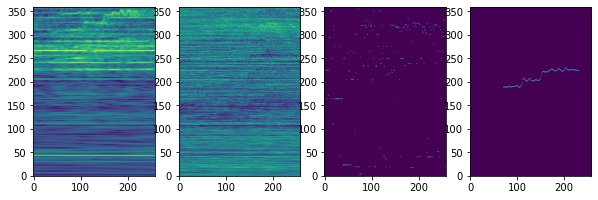

In [22]:
# 逐个比较损失

import evaluate
reload(evaluate)

out_floor = 0

model.eval()

with torch.no_grad():
    for a, b in test_dataloader_non_instrumental:
        X, y = a.cuda(), b.cuda()

        X = X[0:1]
        y = y[0:1]
        
        Xpred = model(X, out_floor)
        Xshow = utils.salience_to_output(Xpred.clone().detach(), threshold=0)
        y_downsample = utils.downsample(y, out_floor).int()
        
        loss = loss_fn(Xpred, y_downsample, threshold=0.4)
        
        print(evaluate.evaluate(Xshow, y_downsample, out_floor))
        
        plt.figure(figsize=(10,10))
        plt.subplot(241)
        plt.imshow(X[0][0].cpu(), origin='lower')
        plt.subplot(242)
        plt.imshow(Xpred[0][0].cpu(), origin='lower')
        plt.subplot(243)
        plt.imshow(Xshow[0][0].cpu(), origin='lower')
        plt.subplot(244)
        plt.imshow(y_downsample[0].cpu(), origin='lower')
        '''
        plt.subplot(234)
        plt.imshow(X[1][0].cpu(), origin='lower')
        plt.subplot(246)
        plt.imshow(Xpred[1][0].cpu(), origin='lower')
        plt.subplot(235)
        plt.imshow(Xshow[1][0].cpu(), origin='lower')
        plt.subplot(236)
        plt.imshow(y_downsample[1].cpu(), origin='lower')
        plt.show()
        '''
        
        print('------------')
        

        break

In [41]:
evaluate.evaluate(y_2.unsqueeze(0), y, 0)

(0.7713178294573644,
 0.6335403726708074,
 0.0,
 0.6335403726708074,
 0.6335403726708074)

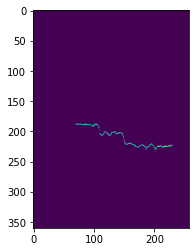

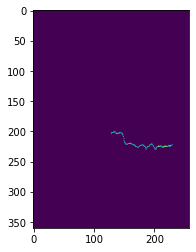

In [40]:
plt.imshow(y[0].cpu())
plt.show()
plt.imshow(y_2[0].cpu())

In [39]:
y_2 = y.clone()
y_2[0, :, 0:129] = 0